# Machine Learning Models and Ensemble Method
---


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
from tqdm import tqdm # progress bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

SEED = 111 # constant seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Train/Test Split:

In [2]:
df = pd.read_csv("data/UFC_TRAIN.csv")

# tackling imbalance issue
#theMin = df["Winner"].value_counts().min()
#minority = df[df["Winner"]==1].iloc[0:theMin]
#undersampleMaj = df[df["Winner"]==0].iloc[0:theMin]
#df = pd.concat([minority, undersampleMaj], axis=0)
#df["Winner"].value_counts()

# train/test split
X = df.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values
X_TRAIN, X_VAL, y_TRAIN, y_VAL = train_test_split(X,y, test_size=0.20, random_state=SEED)


#### Baseline: Always predict red (i.e: 0)

In [3]:
metrics.accuracy_score(np.zeros(len(df.index)),df["Winner"])

0.6779468544174426

Baseline accuracy is 67.96 % in unbalanced dataset

## ML Models
### 1- DNN:
Using a deep neural network with early stopping functionality to prevent divergence of loss & val_loss

In [4]:
# scaling
scaler = MinMaxScaler()
scaler.fit(X_TRAIN)
X_train_scaled = scaler.transform(X_TRAIN)
X_val_scaled = scaler.transform(X_VAL)

print(f"X_train_scaled shape: {X_train_scaled.shape} | X_val_scaled shape: {X_val_scaled.shape} | y_train shape: {y_TRAIN.shape} | y_val shape: {y_VAL.shape}")

# model
dnnClf = Sequential()

# input layer
dnnClf.add(Dense(units=42, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

dnnClf.add(Dense(units=10, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=10, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=10, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))

#dnnClf.add(Dense(units=42, activation='relu'))

# output layer
dnnClf.add(Dense(units=1, activation='sigmoid'))

dnnClf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # prevent divergence of loss & val_loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

X_train_scaled shape: (3522, 42) | X_val_scaled shape: (881, 42) | y_train shape: (3522,) | y_val shape: (881,)


Train on 3522 samples, validate on 881 samples
Epoch 1/400
3522/3522 [==============================] - 3s 799us/sample - loss: 0.6740 - accuracy: 0.6144 - val_loss: 0.6357 - val_accuracy: 0.6697
Epoch 2/400
3522/3522 [==============================] - 1s 178us/sample - loss: 0.6367 - accuracy: 0.6803 - val_loss: 0.6288 - val_accuracy: 0.6697
Epoch 3/400
3522/3522 [==============================] - 0s 138us/sample - loss: 0.6303 - accuracy: 0.6792 - val_loss: 0.6241 - val_accuracy: 0.6697
Epoch 4/400
3522/3522 [==============================] - 0s 133us/sample - loss: 0.6231 - accuracy: 0.6800 - val_loss: 0.6189 - val_accuracy: 0.6697
Epoch 5/400
3522/3522 [==============================] - 0s 138us/sample - loss: 0.6198 - accuracy: 0.6809 - val_loss: 0.6164 - val_accuracy: 0.6686
Epoch 6/400
3522/3522 [==============================] - 0s 141us/sample - loss: 0.6172 - accuracy: 0.6803 - val_loss: 0.6156 - val_accuracy: 0.6697
Epoch 7/400
3522/3522 [==============================] - 0s

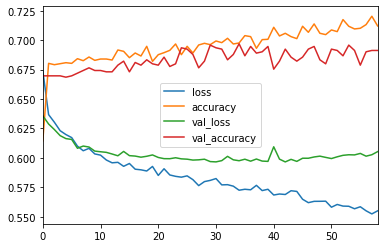

In [5]:
dnnClf.fit(x=X_train_scaled, 
          y=y_TRAIN, 
          epochs=400,
          validation_data=(X_val_scaled, y_VAL), verbose=1,
          callbacks=[early_stop]
          )
model_loss = pd.DataFrame(dnnClf.history.history)
model_loss.plot()

In [6]:
dnnPreds = dnnClf.predict(scaler.transform(X_VAL))
dnnPreds = [round(i[0]) for i in dnnPreds]
target_names = ['class 0', 'class 1']
print("DNN Validation Performance:\n------------------\n",classification_report(y_VAL, dnnPreds , target_names=target_names))

DNN Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.71      0.91      0.80       590
     class 1       0.58      0.25      0.35       291

    accuracy                           0.69       881
   macro avg       0.64      0.58      0.57       881
weighted avg       0.67      0.69      0.65       881



### 2- SVM:
Using a Support Vector Machine with a linear kernel

In [7]:
svmClf = SVC(kernel="linear")
svmClf.fit(X_TRAIN,y_TRAIN)
svmPreds = svmClf.predict(X_VAL)
print("SVM Validation Performance:\n------------------\n",classification_report(y_VAL, svmPreds , target_names=target_names))
# svm hp-tuning with gridSearch
#svm_param = {"kernel":("linear","poly","rbf", "sigmoid"),
#            "C":[1,52,10],
#            "degree":[3,8],
#            "gamma":("auto","scale"),
#            "coef0":[0.001,10,0.5]}
#svmClf = SVC()
#svmGrid = GridSearchCV(svmClf, svm_param,cv=2)
#svmGrid.fit(X_TRAIN, y_TRAIN)

SVM Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.68      0.99      0.81       590
     class 1       0.71      0.05      0.10       291

    accuracy                           0.68       881
   macro avg       0.70      0.52      0.45       881
weighted avg       0.69      0.68      0.57       881



### 3- RF:
Random Forest

In [8]:
rfClf = RandomForestRegressor(n_estimators = 1000)
rfClf.fit(X_TRAIN, y_TRAIN)
rfPreds = rfClf.predict(X_VAL)
rfPreds = [round(i) for i in rfPreds]
print("RF Validation Performance:\n------------------\n",classification_report(y_VAL, rfPreds , target_names=target_names))

RF Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.71      0.89      0.79       590
     class 1       0.55      0.26      0.36       291

    accuracy                           0.68       881
   macro avg       0.63      0.58      0.57       881
weighted avg       0.66      0.68      0.65       881



### 4- XGBOOST:
Gradient Boost

In [9]:
xgbClf = XGBClassifier(n_estimators=200)
xgbClf.fit(X_TRAIN, y_TRAIN)
xgbPreds = xgbClf.predict(X_VAL)
print("XGB Validation Performance:\n------------------\n",classification_report(y_VAL, xgbPreds , target_names=target_names))
#xgbAcc = metrics.accuracy_score(xgbPreds,y_VAL)
#print("XGB Accuracy:",round(xgbAcc,3))

XGB Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.71      0.91      0.79       590
     class 1       0.56      0.23      0.33       291

    accuracy                           0.69       881
   macro avg       0.63      0.57      0.56       881
weighted avg       0.66      0.69      0.64       881



### 5- Logistic Regression (LR):

In [10]:
lrClf = LogisticRegression(solver="newton-cg")
lrClf.fit(X_TRAIN, y_TRAIN)
lrPreds = lrClf.predict(X_VAL)
print("LogReg Validation Performance:\n------------------\n",classification_report(y_VAL, lrPreds , target_names=target_names))


LogReg Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.70      0.92      0.80       590
     class 1       0.56      0.20      0.29       291

    accuracy                           0.68       881
   macro avg       0.63      0.56      0.54       881
weighted avg       0.65      0.68      0.63       881



### 5- Ensemble Method:
Ensemble method aggregates the votes of each model and gives the most frequent vote as output

In [11]:
def predictEnsemble(sample, models=0):
    """predicts the label of a given sample by aggregating votes of number of models.
    by default, models = 0, takes into account all models. Otherwise, for a given list of codes,
    it involves the corresponsing model. codes:
    1: dnn | 2: svm | 3: rf | 4: xgb | 5: lr
    """
    modelsDict = {
        # models predictions dictionary
        1:dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0],
        2:svmClf.predict(sample.reshape(1,-1)).tolist()[0],
        3:rfClf.predict(sample.reshape(1,-1)).tolist()[0],
        4:xgbClf.predict(sample.reshape(1,-1)).tolist()[0],
        5:lrClf.predict(sample.reshape(1,-1)).tolist()[0]
    }
    preds = []
    if models == 0: # use all models
        [preds.append(model) for model in modelsDict.values()]
    else: # use only specified models
        for model_code in models:
            preds.append(modelsDict[model_code])

    #print(preds)
    preds = [round(i) for i in preds] # transform probability to label (threshold 0.5)
    #print(preds)
    #print(max(set(preds), key=preds.count))
    return(max(set(preds), key=preds.count))
ensPreds = []
[ensPreds.append(predictEnsemble(sample, models=[3,4,5])) for sample in tqdm(X_VAL)]
print("Ensemble Validation Performance:\n------------------\n",classification_report(y_VAL, ensPreds , target_names=target_names))


100%|██████████| 881/881 [02:01<00:00,  7.23it/s]

Ensemble Validation Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.70      0.92      0.80       590
     class 1       0.57      0.21      0.31       291

    accuracy                           0.69       881
   macro avg       0.64      0.57      0.55       881
weighted avg       0.66      0.69      0.64       881



## Performance Evaluation on TEST (unseen data):

In [12]:
print("Accuracy on unseen test dataset")
TEST = pd.read_csv("data/UFC_TEST.csv")
X_TEST = TEST.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
y_TEST = TEST["Winner"].values

'''
dnnPreds2 = dnnClf.predict(scaler.transform(X_TEST))
dnnPreds2 = [round(i[0]) for i in dnnPreds2]
dnnAcc2 = metrics.accuracy_score(dnnPreds2, y_TEST)
print("DNN Accuracy:",round(dnnAcc2,3))

svmPreds2 = svmClf.predict(X_TEST)
svmAcc2 = metrics.accuracy_score(svmPreds2, y_TEST)
print("SVM Accuracy:",round(svmAcc2,3))

rfPreds2 = rfClf.predict(X_TEST)
rfPreds2 = [round(i) for i in rfPreds2]
rfAcc2 = metrics.accuracy_score(rfPreds2, y_TEST)
print("RF Accuracy:",round(rfAcc2,3))

xgbPreds2 = xgbClf.predict(X_TEST)
xgbAcc2 = metrics.accuracy_score(xgbPreds2, y_TEST)
print("XGB Accuracy:",round(xgbAcc2,3))

lrPreds2 = lrClf.predict(X_TEST)
lrAcc2 = metrics.accuracy_score(lrPreds2, y_TEST)
print("LogReg Accuracy:",round(lrAcc2,3))
'''
ensPreds_TEST = []
[ensPreds_TEST.append(predictEnsemble(test_sample, models=[3,4,5])) for test_sample in tqdm(X_TEST)]
print("Ensemble TEST Performance:\n------------------\n",classification_report(y_TEST, ensPreds_TEST , target_names=target_names))



  0%|          | 0/232 [00:00<?, ?it/s]

Accuracy on unseen test dataset


100%|██████████| 232/232 [00:32<00:00,  7.07it/s]

Ensemble TEST Performance:
------------------
               precision    recall  f1-score   support

     class 0       0.72      0.93      0.81       157
     class 1       0.62      0.24      0.35        75

    accuracy                           0.71       232
   macro avg       0.67      0.58      0.58       232
weighted avg       0.69      0.71      0.66       232



In [9]:
#accTable = pd.DataFrame({"Model":["DNN", "SVM", "RF", "XGB", "LogReg", "Ensemble"], 
#                         "Val_Accuracy":[dnnAcc, svmAcc, rfAcc, xgbAcc, lrAcc, ensAcc],
#                         "Test_Accuracy":[dnnAcc2, svmAcc2, rfAcc2, xgbAcc2, lrAcc2, ensAcc2]})
#accTable.plot(kind="bar",ylim=(0.5,0.8),x="Model",title="Models Performance on Validation and Test Data")


NameError: name 'dnnAcc2' is not defined

In [15]:
# save models to disk
import pickle
dnnClf.save('resources/dnn_model.h5')
pickle.dump(svmClf, open('resources/svm_model.sav', 'wb'))
pickle.dump(rfClf, open('resources/rf_model.sav', 'wb'))
pickle.dump(xgbClf, open('resources/xgb_model.sav', 'wb'))
pickle.dump(lrClf, open('resources/lr_model.sav', 'wb'))


pickle.dump(scaler, open('resources/scaler.pkl', 'wb'))